# Comprehensive Single Cell Analysis with bmtool

By Gregory Glickert

This tutorial demonstrates multiple methods to load neurons into bmtool's single cell analysis module, and shows how to apply various electrophysiological analysis techniques to any loaded cell model. We'll cover:

1. **Cell Loading Methods**: Allen Database, NEURON HOC templates, and Python class-based models
2. **Analysis Techniques**: Passive properties, Current clamp, Impedance (ZAP), and Frequency-Intensity (FI) curves

This notebook demonstrates that all analysis methods work consistently regardless of how the cell was loaded.

## Part 1: Setup and Compilation

First, we compile the MOD files and set up the analysis environment. This section applies to all cell loading methods.

In [1]:
import os
import glob
import logging
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

from bmtool.singlecell import (
    Passive, CurrentClamp, ZAP, FI, Profiler, run_and_plot,
    load_allen_database_cells
)

%matplotlib inline

# Disable warnings for cleaner output
logging.disable(logging.WARNING)

--No graphics will be displayed.


In [2]:
# if already compiled then lets delete the folder and force a recompile
if os.path.isdir('modfiles/x86_64'):
    os.system("rm -rf modfiles/x86_64")
if os.path.isdir('modfiles/arm64'):
    os.system("rm -rf modfiles/arm64")

# compile the mod files
if not os.path.isdir("modfiles/x86_64"):
    os.chdir('modfiles')
    os.system("nrnivmodl")
    os.chdir("..")

/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles
Mod files: "./AMPA_NMDA_STP.mod" "./CaDynamics.mod" "./Ca_HVA.mod" "./Ca_LVA.mod" "./GABA_A_STP.mod" "./Gfluct.mod" "./Ih.mod" "./Im.mod" "./Im_v2.mod" "./K_P.mod" "./K_T.mod" "./Kd.mod" "./Kv2like.mod" "./Kv3_1.mod" "./NaTa.mod" "./NaTs.mod" "./NaV.mod" "./Nap.mod" "./SK.mod" "./cadad.mod" "./cal2.mod" "./can_mig.mod" "./exp2syn_stp.mod" "./gap.mod" "./h_kole.mod" "./imCA3.mod" "./k.mod" "./kBK.mod" "./kap_BS.mod" "./kdmc_BS.mod" "./kdrCA3.mod" "./kdr_BS.mod" "./kdrinter.mod" "./leak.mod" "./na.mod" "./nainter.mod" "./napCA3.mod" "./natCA3.mod" "./nax_BS.mod" "./vecevent_coreneuron.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../AMPA_NMDA_STP.mod
 -> NMODL ../Ca_HVA.mod
 -> NMODL ../CaDynamics.mod
 -> NMODL ../Ca_LVA.mod
 -> NMODL ../GABA_A_STP.mod
 -> NMODL ../Gfluct.mod
 -> NMODL ../Ih.mod
 -> NMODL ../Im.mod
 -> NMODL ../Im_v2.mod
 -> NMODL ../K_P.mod
 -> NMODL

Translating AMPA_NMDA_STP.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/AMPA_NMDA_STP.c
Translating Ca_HVA.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Ca_HVA.c
Translating CaDynamics.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/CaDynamics.c
Thread Safe
Thread Safe
Thread Safe
Translating Ca_LVA.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Ca_LVA.c
Thread Safe
Translating GABA_A_STP.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/GABA_A_STP.c
Translating Ih.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Ih.c
Translating Gfluct.mod into /home/gjgpb9/V1-Network-Model/bmtool/docs/examples/notebooks/single_cell/modfiles/x86_64/Gfluct.c
Thread Safe
Notice: This mechanism cannot be use

 -> NMODL ../kap_BS.mod
 -> NMODL ../kdmc_BS.mod
 -> NMODL ../kdrCA3.mod
 -> NMODL ../kdr_BS.mod
 -> NMODL ../kdrinter.mod
 -> NMODL ../leak.mod
 -> NMODL ../na.mod
 -> NMODL ../nainter.mod
 -> NMODL ../napCA3.mod
 -> NMODL ../natCA3.mod
 -> NMODL ../nax_BS.mod
 -> NMODL ../vecevent_coreneuron.mod
Notice: ARTIFICIAL_CELL is a synonym for POINT_PROCESS which hints that it
only affects and is affected by discrete events. As such it is not
located in a section and is not associated with an integrator
 -> Compiling AMPA_NMDA_STP.c
 -> Compiling CaDynamics.c
 -> Compiling Ca_HVA.c
 -> Compiling Ca_LVA.c
 -> Compiling GABA_A_STP.c
 -> Compiling Gfluct.c
 -> Compiling Ih.c
 -> Compiling Im.c
 -> Compiling Im_v2.c
 -> Compiling K_P.c
 -> Compiling K_T.c
 -> Compiling Kd.c
 -> Compiling Kv2like.c
 -> Compiling Kv3_1.c
 -> Compiling NaTa.c
 -> Compiling NaTs.c
 -> Compiling NaV.c
 -> Compiling Nap.c
 -> Compiling SK.c
 -> Compiling cadad.c
 -> Compiling cal2.c
 -> Compiling can_mig.c
 -> Compili

## Part 2: Cell Loading Methods

bmtool supports three different approaches to load neuron models. Each method returns a cell creator that can be used with any analysis function.

### 2.1: Loading Allen Database Cells

Download and load a realistic neuron model from the Allen Institute Brain Observatory.

In [3]:
# Method 1: Allen Database Cell

# this downloads from allen database which is already done
# from allensdk.api.queries.biophysical_api import BiophysicalApi

# # Download cell model from Allen
# bp = BiophysicalApi()
# bp.cache_stimulus = False
# neuronal_model_id = 472451419  # Example: Layer 5 Pyramidal Cell
# bp.cache_data(neuronal_model_id)
    
dynamic_params = "386049446_fit.json"
morphology = "Nr5a1-Cre_Ai14-177334.05.01.01_491459171_m.swc"

# Create Allen cell loader
cell1 = load_allen_database_cells(
    morphology=morphology,
    dynamic_params=dynamic_params,
    model_processing='aibs_allactive'
)


In [4]:
profiler = Profiler(template_dir='.', mechanism_dir='modfiles', dt=0.05)

It is important to note the order in which we are doing things for loading the Allen database cell. You need to first load the cell, but do not call the class. Then load the mod files(here done with the profiler to also get our template setup for the cell2) and then initalize cell1.

In [5]:
cell1 = cell1()

### 2.2: Loading NEURON HOC Template Cells

Use pre-defined HOC template files for standard neuronal models.

In [ ]:
# Method 2: NEURON HOC Template
# The template is loaded by passing the template name as a string
cell2 = 'CP_Cell'  # Change this to match your template name

### 2.3: Loading Python Class-Based Cells

Define and use custom neuron models programmatically using Python classes.

In [7]:
# Method 3: Python Class-Based Cell

h.load_file("stdrun.hoc")

class SimpleSoma(object):
    """Single-section cell: A soma with leak, sodium, and potassium channels."""
    def __init__(self):
        self.create_sections()
        self.build_topology()
        self.build_subsets()
        self.define_geometry()
        self.define_biophysics()
    #
    def create_sections(self):
        """Create the sections of the cell."""
        # NOTE: cell=self is required to tell NEURON of this object.
        self.soma = h.Section(name='soma', cell=self)
    #
    def build_topology(self):
        """Connect the sections of the cell to build a tree."""
        # Single section - no connections needed
        pass
    #
    def define_geometry(self):
        """Set the 3D geometry of the cell."""
        self.soma.L = 500     # soma length um
        self.soma.diam = 500  # soma diameter um
        h.define_shape()      # Translate into 3D points.
    #
    def define_biophysics(self):
        """Assign the membrane properties across the cell."""
        for sec in self.all: # 'all' defined in build_subsets
            sec.cm = 1       # membrane capacitance uF/cm2
            sec.Ra = 30      # ohm-cm
        
        # Insert leak channel
        self.soma.insert('leak')  # Leak channel
        self.soma.glbar_leak = 0.0003  # S/cm2
        self.soma.el_leak = -60  # mV
        
        # Insert sodium channel
        self.soma.insert('na')  # Sodium channel
        self.soma.gnabar_na = 0.22  # S/cm2
        self.soma.nao = 79.8  # extracellular Na concentration
        
        # Insert potassium channel
        self.soma.insert('k')  # Potassium channel
        self.soma.gkbar_k = 0.036  # S/cm2
        self.soma.ki = 69.35  # intracellular K concentration
    #
    def build_subsets(self):
        """Build subset lists. For now we define 'all'."""
        self.all = h.SectionList()
        self.all.wholetree(sec=self.soma)


cell3 = SimpleSoma()

## Part 3: Analysis Methods

Now we demonstrate all available analysis techniques. These methods work with any of the cell loading approaches above.

### Setup Analysis Parameters

Define comprehensive settings for each analysis method.

In [8]:
# Analysis settings dictionary
# These parameters can be tuned based on your specific cell type and experimental constraints

analysis_settings = {
    'Passive': {
        'celsius': 26.0,
        'kwargs': {
            'inj_amp': -50.0,
            'inj_delay': 1500.0,
            'inj_dur': 1000.0,
            'tstop': 2500.0,
            'method': 'exp2'  # options: 'exp2', 'exp', 'simple'
        }
    },
    'CurrentClamp': {
        'celsius': 34.0,
        'kwargs': {
            'inj_amp': 130.0,
            'inj_delay': 1500.0,
            'inj_dur': 1000.0,
            'tstop': 3000.0,
            'threshold': -15.0
        }
    },
    'ZAP': {
        'celsius': 34.0,
        'kwargs': {
            'inj_amp': 100.0,
            'inj_delay': 1000.0,
            'inj_dur': 15000.0,
            'tstop': 15500.0,
            'fstart': 0.0,
            'fend': 15.0,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.0,
        'kwargs': {
            'i_start': 0.0,
            'i_stop': 2000.0,
            'i_increment': 100.0,
            'tstart': 1500.0
        }
    }
}

### Helper Functions for FI Curve Analysis

Define utility functions for analyzing frequency-current relationships.

In [9]:
def find_slope(X, Y):
    """Find the slope and intercept using least squares regression."""
    A = np.vstack([X, np.ones_like(X)]).T
    m, c = np.linalg.lstsq(A, Y, rcond=None)[0]
    return m, c


def fit_slope_to_max_y(X, Y):
    """Fit a line from first spike to maximum spike frequency.
    
    This captures the linear region of the FI curve where the relationship
    is most pronounced.
    """
    # Find where Y > 0
    positive_data = Y > 0
    X_positive = X[positive_data]
    Y_positive = Y[positive_data]
    
    if len(Y_positive) == 0:
        return None, None, X, Y
    
    # Find the index of the maximum Y value
    max_idx = np.argmax(Y_positive)
    
    # Only use data from first spike to max
    X_fit = X_positive[:max_idx + 1]
    Y_fit = Y_positive[:max_idx + 1]
    
    m, c = find_slope(X_fit, Y_fit)
    return m, c, X_fit, Y_fit


def find_rheobase(X, Y):
    """Find the rheobase: minimum current required to evoke a spike."""
    non_zero_indices = np.nonzero(Y)[0]
    if len(non_zero_indices) > 0:
        rheobase = X[non_zero_indices[0]]
        return rheobase
    return None


### 3.1: Passive Properties Analysis

Analyze membrane properties under hyperpolarizing current injection.

Injection location: Biophys1[0].soma[0](0.5)
Recording: Biophys1[0].soma[0](0.5)._ref_v
Running simulation for passive properties...

V Rest: -99.70 (mV)
Resistance: 362.19 (MOhms)
Membrane time constant: 54.19 (ms)

V_rest Calculation: Voltage taken at time 1500.0 (ms) is
-99.70 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-117.81 - (-99.70)) / (-0.05 - 0)
18.11 (mV) / 0.05 (nA) = 362.19 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constrained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-117.80, 14.49, 3.61, 54.19, 2.77)
Membrane time constant is determined from the slowest exponential term: 54.19 (ms)

Sag potential: v_sag = v_peak - v_final = 0.00 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = -0.000



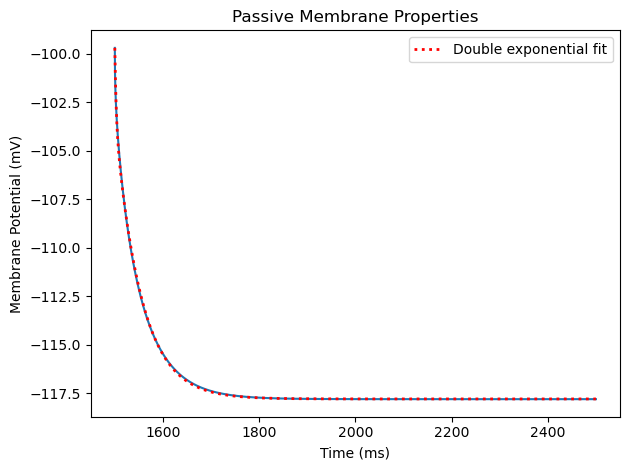

In [10]:
proc_settings = analysis_settings['Passive']
h.celsius = proc_settings['celsius']

sim_passive = Passive(cell1, **proc_settings['kwargs'])

X_passive, Y_passive = run_and_plot(
    sim_passive,
    title='Passive Membrane Properties',
    xlabel='Time (ms)',
    ylabel='Membrane Potential (mV)',
    plot_injection_only=True
)

# Add exponential fit
if sim_passive.method == 'exp2':
    plt.gca().plot(*sim_passive.double_exponential_fit(), 'r:', linewidth=2, label='Double exponential fit')
    plt.legend()
elif sim_passive.method == 'exp':
    plt.gca().plot(*sim_passive.single_exponential_fit(), 'r:', linewidth=2, label='Single exponential fit')
    plt.legend()

plt.tight_layout()
plt.show()

### 3.2: Current Clamp Analysis

Measure voltage response to current injection - fundamental for understanding cell excitability.

Injection location: <__main__.SimpleSoma object at 0x7f9d38140c10>.soma(0.5)
Recording: <__main__.SimpleSoma object at 0x7f9d38140c10>.soma(0.5)._ref_v
Current clamp simulation running...

Number of spikes: 179



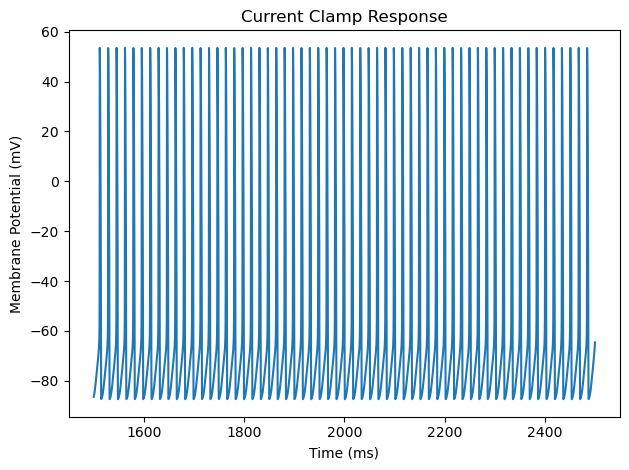

In [11]:
proc_settings = analysis_settings['CurrentClamp']
h.celsius = proc_settings['celsius']

sim_cc = CurrentClamp(cell3, **proc_settings['kwargs'])

X_cc, Y_cc = run_and_plot(
    sim_cc,
    title='Current Clamp Response',
    xlabel='Time (ms)',
    ylabel='Membrane Potential (mV)',
    plot_injection_only=True
)

plt.tight_layout()
plt.show()

### 3.3: Impedance Amplitude Profile (ZAP)

Analyze frequency response using a chirp stimulus to measure impedance at different frequencies.

Injection location: CP_Cell[0].soma[0](0.5)
Recording: CP_Cell[0].soma[0](0.5)._ref_v
ZAP current simulation running...

Chirp current injection with frequency changing from 0 to 15 Hz over 15 seconds
Impedance is calculated as the ratio of FFT amplitude of membrane voltage to FFT amplitude of chirp current



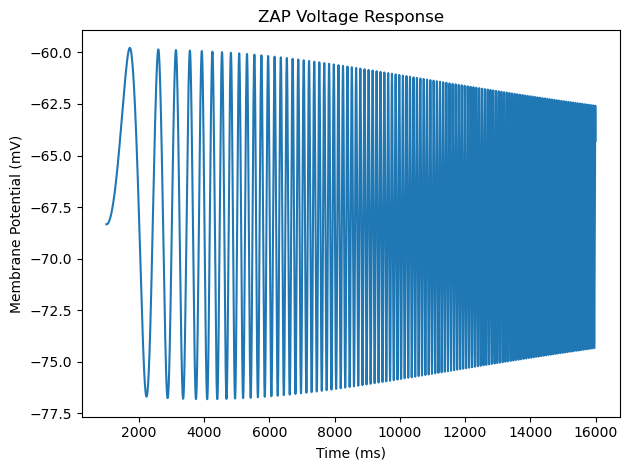

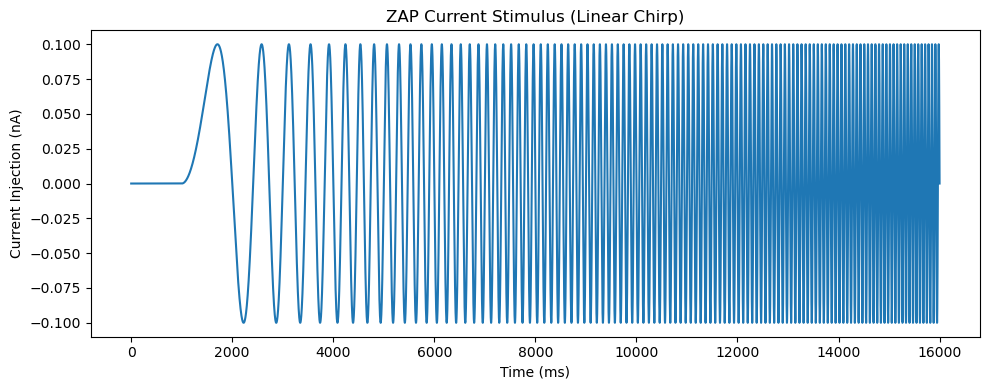

Resonant Peak Frequency: 0.333 (Hz)


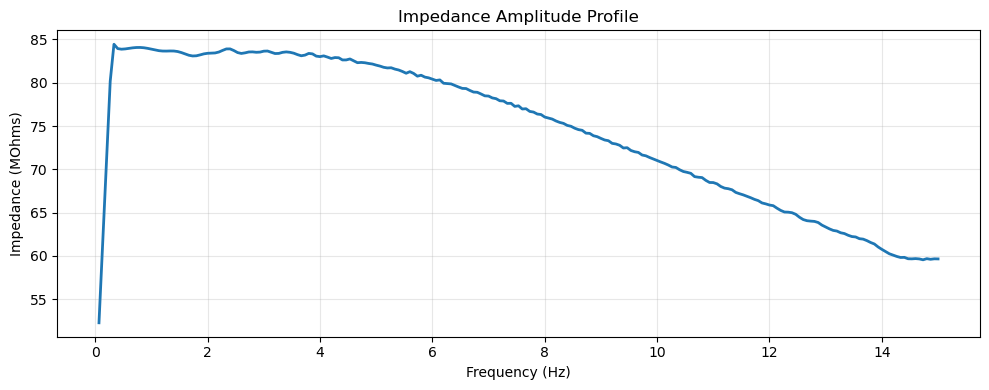

Resonant frequency: 0.33 Hz
Maximum impedance: 84.45 MOhms


In [12]:
proc_settings = analysis_settings['ZAP']
h.celsius = proc_settings['celsius']

sim_zap = ZAP(cell2, **proc_settings['kwargs'])

# Plot voltage response
X_zap, Y_zap = run_and_plot(
    sim_zap,
    title='ZAP Voltage Response',
    xlabel='Time (ms)',
    ylabel='Membrane Potential (mV)',
    plot_injection_only=True
)
plt.tight_layout()
plt.show()

# Plot ZAP current stimulus
plt.figure(figsize=(10, 4))
plt.plot(X_zap, sim_zap.zap_vec)
plt.title('ZAP Current Stimulus (Linear Chirp)')
plt.xlabel('Time (ms)')
plt.ylabel('Current Injection (nA)')
plt.tight_layout()
plt.show()

# Plot impedance profile
plt.figure(figsize=(10, 4))
freq, imp = sim_zap.get_impedance(smooth=9)
plt.plot(freq, imp, linewidth=2)
plt.title('Impedance Amplitude Profile')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedance (MOhms)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find resonant frequency
if len(freq) > 0:
    max_imp_idx = np.argmax(imp)
    resonant_freq = freq[max_imp_idx]
    max_imp = imp[max_imp_idx]
    print(f"Resonant frequency: {resonant_freq:.2f} Hz")
    print(f"Maximum impedance: {max_imp:.2f} MOhms")

### 3.4: Frequency-Intensity (FI) Curve Analysis

Measure the relationship between injected current and spike frequency

Injection location: CP_Cell[1].soma[0](0.5)
Recording: CP_Cell[1].soma[0](0.5)._ref_v
Running simulations for FI curve...

Results
    Injection (pA):  number of spikes
0               0.0                 0
1             100.0                 0
2             200.0                15
3             300.0                23
4             400.0                31
5             500.0                40
6             600.0                49
7             700.0                59
8             800.0                70
9             900.0                 4
10           1000.0                 2
11           1100.0                 2
12           1200.0                 2
13           1300.0                 2
14           1400.0                 2
15           1500.0                 1
16           1600.0                 1
17           1700.0                 1
18           1800.0                 1
19           1900.0                 1



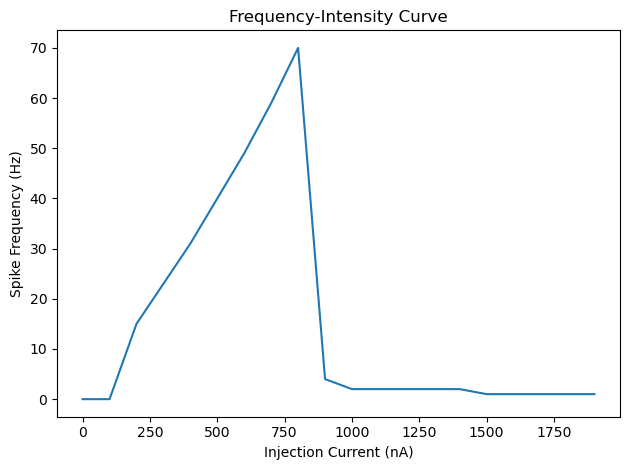

In [13]:
proc_settings = analysis_settings['FI']
h.celsius = proc_settings['celsius']

sim_fi = FI(cell2, **proc_settings['kwargs'])

X_fi, Y_fi = run_and_plot(
    sim_fi,
    title='Frequency-Intensity Curve',
    xlabel='Injection Current (nA)',
    ylabel='Spike Frequency (Hz)'
)
plt.tight_layout()
plt.show()

### FI Curve Post-Processing and Analysis

In [14]:
# Fit linear portion of FI curve
m, c, X_fit, Y_fit = fit_slope_to_max_y(X_fi, Y_fi)

# Find rheobase
rheobase = find_rheobase(X_fi, Y_fi)
print(f"  Rheobase (minimum current for firing): {rheobase:.1f} pA")

  Rheobase (minimum current for firing): 200.0 pA
